# Empirical1a - Use Miller data set to demonstrate that during task states, correlated variability is quenched
## Using h5f data for faster i/o



## Takuya Ito
#### 08/01/2018

In [165]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
import bct
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.api as sm
import statsmodels.sandbox.stats.multicomp as mc
import sklearn
import seaborn as sns
plt.style.use("ggplot")
plt.rcParams["font.family"] = "FreeSans"
import nibabel as nib
import pandas as pd
import sys
import h5py
sys.path.append('../')
import dimensionality

In [166]:
sessions = ['100706']
# sessions = ['100706','100730','100804','100820','100827','100913','100921','101024','101122','101128',
#             '101207','101217','110110_01','110115_01','100724','100731','100817','100823','100828',
#             '100915','101008','101027','101123','101202','101209','110106','110110_02','110120','100725',
#             '100802','100818','100824','100907','100917','101009','101028','101124','101203','101210',
#             '110107_01','110111_01','110121','100726','100803','100819','100826','100910','100920','101023',
#             '101030','101127','101206','101216','110107_02','110111_02']

datadir = '/projects3/TaskFCMech/data/nhpData/'
tmin = -4000 # in ms
tmax = 4000 # in ms, this was my own doing


# 1.0 Load single session

In [167]:
# session = '100706'
# session = '100730'
session = '100804'
# session = '100913'

h5f = h5py.File(datadir + session + '.h5','r')
sta = h5f['sta'][:].T.copy()
h5f.close()

#### Load other meta-data associated with neurons + task info

In [168]:
taskInfo = pd.read_csv(datadir + session + '_trialInfoAllTasks.csv')
unitInfo = pd.read_csv(datadir + session + '_unitInfo.csv')
networkdef = unitInfo['area'].astype(str)

# Create a network order
locations = np.unique(networkdef)
networkorder = []
xticks = {}
counter = 0
for loc in locations:
    ind = np.where(networkdef==loc)[0]
    networkorder.extend(ind)
    counter += len(ind)
    xticks[counter] = loc
    
    
networkorder = np.asarray(networkorder)
networkorder.shape = (len(networkorder),1)


## Create spike-triggered average response, across all rules/stims

#### Use sliding window, 50ms sliding-window moving in 10ms (Churchland et al., 2010, Nat Neurosci)

In [169]:
def slidingWindow(data,binSize=50,shiftSize=10,nproc=10):
    """
    data - organized region x time (ms) x trial
    binsize - window size to compute number of spikes
    shiftsize - shift window by this amount
    
    Effectively downsamples data
    """
    nCells = data.shape[0]
    tLength = data.shape[1]
    nTrials = data.shape[2]
    
    ###
    
    inputs = []
    for trial in range(nTrials):
        inputs.append((data[:,:,trial],binSize,shiftSize))
        
    pool = mp.Pool(processes=nproc)
    results = pool.map_async(_slide,inputs).get()
    pool.close()
    pool.join()
    
    out = []
    for result in results:
        out.append(result.T)
        
    outarray = np.zeros((result.shape[1],result.shape[0],nTrials))
    for i in range(nTrials):
        outarray[:,:,i] = out[i]

    return outarray

### Helper function for parallel processing
def _slide((trialdata,binSize,shiftSize)):
    tLength = trialdata.shape[1]
    
    downSampledData = []
    i = 0
    while i < (tLength-binSize):
        downSampledData.append(np.sum(trialdata[:,i:(i+binSize)],axis=1))
        i += shiftSize

    return np.asarray(downSampledData)
        

## Compute downsampled firing rate using 50ms bins and 10ms shift

In [170]:
out = slidingWindow(sta,binSize=50,shiftSize=10,nproc=20)
time = np.linspace(tmin,tmax,out.shape[1])
# out = stats.zscore(out,axis=1)

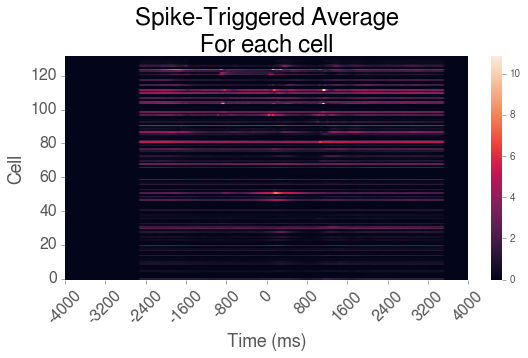

In [171]:
sta_average = np.nanmean(out,axis=2)
plt.figure(figsize=(8,4))
ax = sns.heatmap(sta_average,cbar_kws={'fraction':0.046},yticklabels=20);
plt.title("Spike-Triggered Average\nFor each cell", fontname='FreeSans',fontsize=24);
plt.ylabel('Cell',fontname='FreeSans',fontsize=18);
plt.xlabel('Time (ms)', fontname='FreeSans', fontsize=18);
plt.yticks(fontsize=16,fontname='FreeSans',rotation=0)
plt.xticks(np.linspace(0,len(time),11),np.linspace(tmin,tmax,11,dtype=int),fontsize=16,fontname='FreeSans',rotation=45)
ax.invert_yaxis()

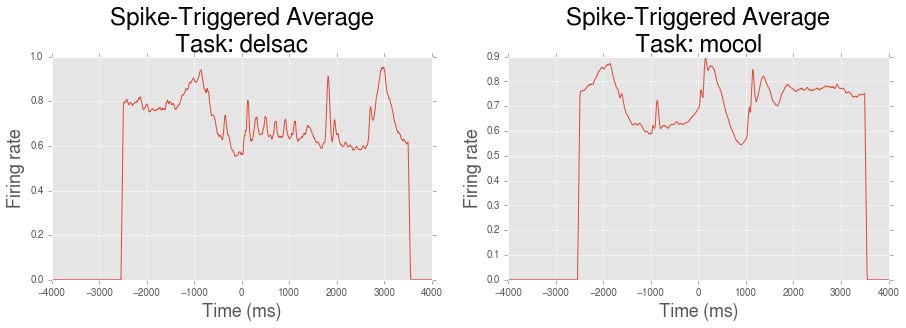

In [172]:
sta_byTaskAvg = {}
tasksByTrial = taskInfo['task'].astype(str)
plt.figure(figsize=(15,4))
i = 1
for task in np.unique(tasksByTrial):
    task_ind = np.where(tasksByTrial==task)[0]
    sta_byTaskAvg[task] = np.mean(out[:,:,task_ind],axis=2)
    plt.subplot(1,2,i)
    plt.title("Spike-Triggered Average\nTask: " + task, fontname='FreeSans',fontsize=24);
    plt.ylabel('Firing rate',fontname='FreeSans',fontsize=18);
    plt.xlabel('Time (ms)', fontname='FreeSans', fontsize=18);
    plt.plot(time,np.mean(sta_byTaskAvg[task],axis=0));
    i += 1
# sns.barplot(time, tmp);

# For noise correlation analysis, we need to remove the spike-triggered average

In [173]:
sta_removed = np.zeros(out.shape)
for cell in range(out.shape[0]):
    for trial in range(out.shape[2]):
        task = taskInfo['task'][trial]
        sta_removed[cell,:,trial] = out[cell,:,trial] - sta_byTaskAvg[task][cell,:]

### Now verify that the signal has been removed - the average across all residuals should look like noise

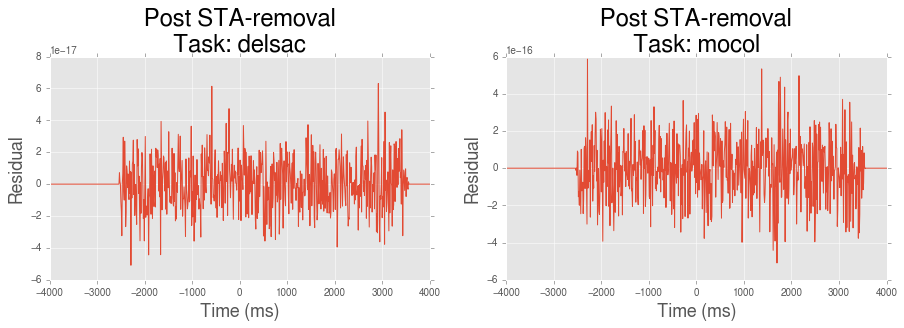

In [174]:
tmp = {}
plt.figure(figsize=(15,4))
i = 1
for task in np.unique(tasksByTrial):
    task_ind = np.where(tasksByTrial==task)[0]
    tmp[task] = np.mean(sta_removed[:,:,task_ind],axis=2)
    plt.subplot(1,2,i)
    plt.title("Post STA-removal\nTask: " + task, fontname='FreeSans',fontsize=24);
    plt.ylabel('Residual',fontname='FreeSans',fontsize=18);
    plt.xlabel('Time (ms)', fontname='FreeSans', fontsize=18);
    plt.plot(time,np.mean(tmp[task],axis=0));
#     plt.plot(time,tmp[task][0,:]);
    i += 1

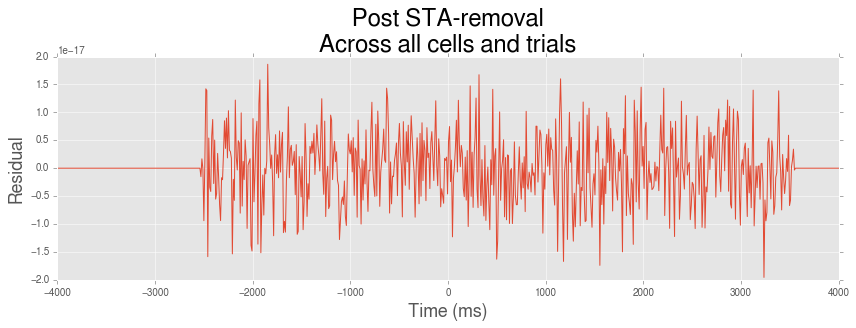

In [175]:
tmp = np.mean(np.mean(sta_removed,axis=2),axis=0)
plt.figure(figsize=(14,4))
plt.plot(time,tmp)
plt.title("Post STA-removal\nAcross all cells and trials", fontname='FreeSans',fontsize=24);
plt.ylabel('Residual',fontname='FreeSans',fontsize=18);
plt.xlabel('Time (ms)', fontname='FreeSans', fontsize=18);

# Compute noise correlation before and after stimulus onset, for all pair of neurons

In [176]:
sta_removed2 = np.zeros(sta_removed.shape)
for trial in range(sta_removed.shape[2]):
    sta_removed2[:,:,trial] = stats.zscore(sta_removed[:,:,trial],axis=1)

In [177]:
# Basic parameters
nCells = sta_removed.shape[0]
nTrials = sta_removed.shape[2]
# # identify indices to start and end correlation calculation
# preStimStart = np.min(np.where(time>-2400)[0])
# preStimEnd = np.min(np.where(time>-1500)[0])
# #
# postStimStart = np.min(np.where(time>-1400)[0])
# postStimEnd = np.min(np.where(time>-500)[0])

# Create empty arrays to store noise correlations
preStimNoiseCorr = np.zeros((nCells,nCells,nTrials))
postStimNoiseCorr = np.zeros((nCells,nCells,nTrials))
preCorr_avg = np.zeros((nTrials,))
postCorr_avg = np.zeros((nTrials,))

# Create empty arrays to store SD values
preStimNoiseSD = np.zeros((nCells,nTrials))
postStimNoiseSD = np.zeros((nCells,nTrials))

# Create empty arrays to store mean FR values
preStimFR = np.zeros((nCells,nTrials))
postStimFR = np.zeros((nCells,nTrials))

dimensionalityPre = np.zeros((nTrials,))
dimensionalityPost = np.zeros((nTrials,))

badTrials = []
badTrial1 = 0
badTrial2 = 0
for trial in range(nTrials):
    # First identify the beginning of recording (prior to taskStart)
    preStimStart = np.min(np.where(sta_removed[0,:,trial]!=0)[0])
    try:
        preStimEnd = np.max(np.where(time<(taskInfo['fixptOn'][trial])*1000)[0]) # Convert trial start times to ms
#         preStimEnd = np.max(np.where(time<(taskInfo['fixptOn'][trial])*1000)[0]) # Convert trial start times to ms
    except:
        badTrials.append(trial)
        badTrial1 += 1
        continue
    nTPs = preStimEnd - preStimStart
    if nTPs<15:
        badTrials.append(trial)
        badTrial2 += 1
        continue

#     postStimStart = np.min(np.where(time>(taskInfo['fixptOn'][trial]*1000))[0])
    postStimStart = np.min(np.where(time>=0)[0])
    postStimEnd = postStimStart + nTPs
    
#     if trial%100==0:
#         print 'Window duration:', nTPs
#         print '\tPreStimStart:', preStimStart, '| PreStimEnd:', preStimEnd
#         print '\tPostStimStart:', postStimStart, '| PostStimEnd:', postStimEnd
    
    # Noise correlation calculation
    triu_ind = np.triu_indices(nCells,k=1)
    A = np.corrcoef(sta_removed[:,preStimStart:preStimEnd,trial])
    nan_ind = np.isnan(A)
    A[nan_ind] = 0
    np.fill_diagonal(A,0)
    preStimNoiseCorr[:,:,trial] = np.arctanh(A)
    preCorr_avg[trial] = np.nanmean(np.arctanh(A))
    tmp = np.cov(sta_removed[:,preStimStart:preStimEnd,trial])
    nan_ind = np.isnan(tmp)
    tmp[nan_ind] = 0
    dimensionalityPre[trial] = dimensionality.getDimensionality(tmp)
    
    A = np.corrcoef(sta_removed[:,postStimStart:postStimEnd,trial])
    nan_ind = np.isnan(A)
    A[nan_ind] = 0
    np.fill_diagonal(A,0)
    postStimNoiseCorr[:,:,trial] = np.arctanh(A)
    postCorr_avg[trial] = np.nanmean(np.arctanh(A))
    tmp = np.cov(sta_removed[:,postStimStart:postStimEnd,trial])
    nan_ind = np.isnan(tmp)
    tmp[nan_ind] = 0
    dimensionalityPost[trial] = dimensionality.getDimensionality(tmp)
    
    # SD calculation
    preStimNoiseSD[:,trial] = np.std(sta_removed[:,preStimStart:preStimEnd,trial],axis=1)
    postStimNoiseSD[:,trial] = np.std(sta_removed[:,postStimStart:postStimEnd,trial],axis=1)
    
    # FR calculation
    preStimFR[:,trial] = np.mean(out[:,preStimStart:preStimEnd,trial],axis=1)
    postStimFR[:,trial] = np.mean(out[:,postStimStart:postStimEnd,trial],axis=1)
        
badTrials = np.asarray(badTrials)
preStimNoiseCorr = np.delete(preStimNoiseCorr,badTrials,axis=2)
postStimNoiseCorr = np.delete(postStimNoiseCorr,badTrials,axis=2)
preCorr_avg = np.delete(preCorr_avg,badTrials,axis=0)
postCorr_avg = np.delete(postCorr_avg,badTrials,axis=0)
preStimNoiseSD = np.delete(preStimNoiseSD,badTrials,axis=1)
postStimNoiseSD = np.delete(postStimNoiseSD,badTrials,axis=1)
preStimFR = np.delete(preStimFR,badTrials,axis=1)
postStimFR = np.delete(postStimFR,badTrials,axis=1)
dimensionalityPre = np.delete(dimensionalityPre,badTrials,axis=0)
dimensionalityPost = np.delete(dimensionalityPost,badTrials,axis=0)

print 'Total number of bad Trials:', badTrial1 + badTrial2, '/', nTrials
print '\tNumber of Bad Trials 1', badTrial1
print '\tNumber of Bad Trials 2', badTrial2

Total number of bad Trials: 222 / 1488
	Number of Bad Trials 1 47
	Number of Bad Trials 2 175


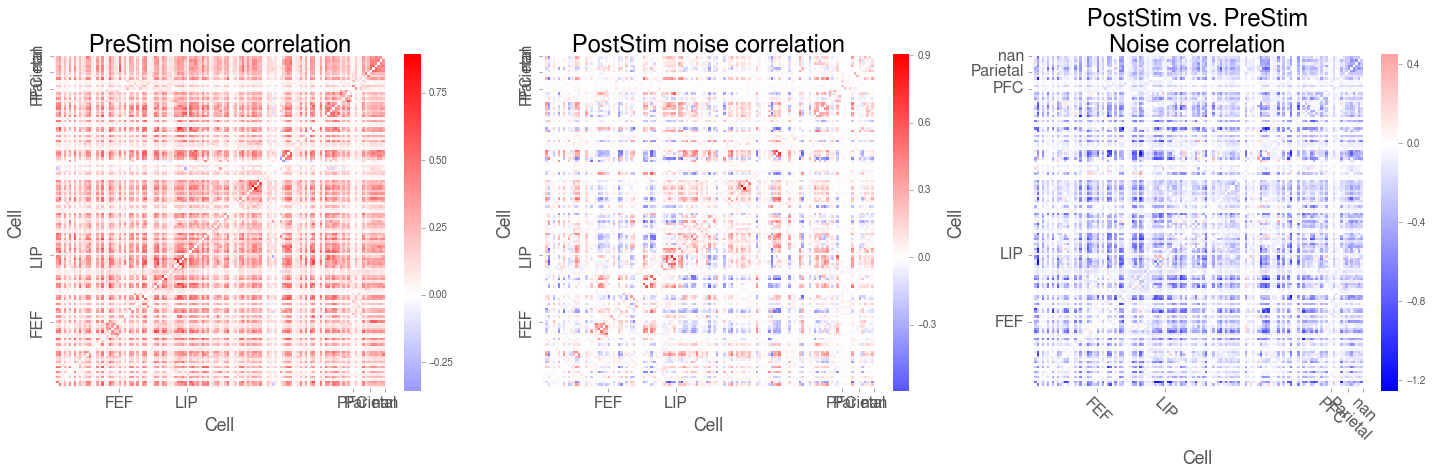

In [178]:
plt.figure(figsize=(20,7))
plt.subplot(131)
ax = sns.heatmap(np.tanh(np.nanmean(preStimNoiseCorr,2))[networkorder,networkorder.T],square=True,center=0,cmap='bwr',xticklabels=20,yticklabels=20,cbar_kws={'fraction':0.046})
plt.xlabel('Cell',fontsize=18,fontname='FreeSans')
plt.ylabel('Cell',fontsize=18,fontname='FreeSans')
plt.xticks(xticks.keys(),xticks.values(),fontsize=16,fontname='FreeSans')
plt.yticks(xticks.keys(),xticks.values(),fontsize=16,fontname='FreeSans')
plt.title('PreStim noise correlation',fontsize=24,fontname='FreeSans')
ax.invert_yaxis()

plt.subplot(132)
ax = sns.heatmap(np.tanh(np.nanmean(postStimNoiseCorr,2))[networkorder,networkorder.T],square=True,center=0,cmap='bwr',xticklabels=20,yticklabels=20,cbar_kws={'fraction':0.046})
plt.xlabel('Cell',fontsize=18,fontname='FreeSans')
plt.ylabel('Cell',fontsize=18,fontname='FreeSans')
plt.xticks(xticks.keys(),xticks.values(),fontsize=16,fontname='FreeSans')
plt.yticks(xticks.keys(),xticks.values(),fontsize=16,fontname='FreeSans')
plt.title('PostStim noise correlation',fontsize=24,fontname='FreeSans')
ax.invert_yaxis()


plt.subplot(133)
# Post-stim versus Pre-stim t-test
t, p = stats.ttest_rel(postStimNoiseCorr,preStimNoiseCorr,axis=2)
diff = np.nanmean(postStimNoiseCorr,axis=2)-np.nanmean(preStimNoiseCorr,axis=2)
triu_ind = np.triu_indices(nCells,k=1)
qs = np.zeros((p.shape))
qs[triu_ind] = mc.fdrcorrection0(p[triu_ind])[0]
qs = qs + qs.T
sigdiff = np.multiply(diff,qs)
ax = sns.heatmap(sigdiff[networkorder,networkorder.T],square=True,center=0,cmap='bwr',xticklabels=20,yticklabels=20,cbar_kws={'fraction':0.046})
plt.xlabel('Cell',fontsize=18,fontname='FreeSans')
plt.ylabel('Cell',fontsize=18,fontname='FreeSans')
plt.xticks(xticks.keys(),xticks.values(),rotation=-45,fontsize=16,fontname='FreeSans')
plt.yticks(xticks.keys(),xticks.values(),fontsize=16,rotation=0,fontname='FreeSans')
plt.title('PostStim vs. PreStim\nNoise correlation',fontsize=24,fontname='FreeSans')
ax.invert_yaxis()
plt.tight_layout()
# plt.savefig('NoiseCorrelation_AllCells.pdf')

## Compute dimensionality of post-stim correlations vs pre-stim correlations

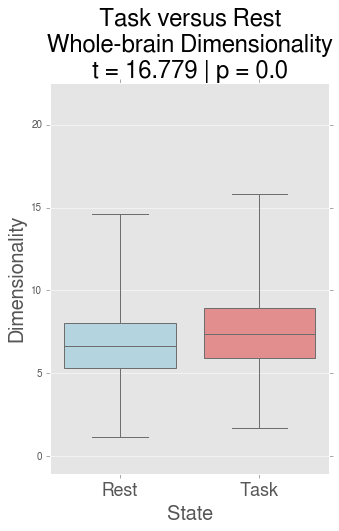

In [179]:
# df_dimensionality = {}
# df_dimensionality['State'] = []
# df_dimensionality['Trial'] = []
# df_dimensionality['Dimensionality'] = []
# for trial in range(postStimNoiseCorr.shape[2]):
#     df_dimensionality['State'].append('Task')
#     df_dimensionality['Trial'].append(trial)
#     tmp = postStimNoiseCorr[:,:,trial].copy()
#     np.fill_diagonal(tmp,1)
#     df_dimensionality['Dimensionality'].append(dimensionality.getDimensionality(tmp))
    
#     df_dimensionality['State'].append('Rest')
#     df_dimensionality['Trial'].append(trial)
#     tmp = preStimNoiseCorr[:,:,trial].copy()
#     np.fill_diagonal(tmp,1)
#     df_dimensionality['Dimensionality'].append(dimensionality.getDimensionality(tmp))
        
# df_dimensionality = pd.DataFrame(df_dimensionality)

# Draw a nested boxplot to show bills by day and time
plt.figure(figsize=(5,7))
# tmprest = df_dimensionality.loc[df_dimensionality['State']=='Rest']
# tmptask = df_dimensionality.loc[df_dimensionality['State']=='Task']
t, p = stats.ttest_rel(dimensionalityPost,dimensionalityPre)

sns.boxplot(data=[dimensionalityPre,dimensionalityPost],
            palette=["#add8e6","#f08080"],
            whis=np.inf)
plt.title('Task versus Rest\nWhole-brain Dimensionality\nt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)),fontsize=24,fontname='FreeSans')
plt.ylabel('Dimensionality',fontsize=20,fontname='FreeSans')
plt.xlabel('State',fontsize=20,fontname='FreeSans')
plt.xticks(np.arange(2),['Rest','Task'],fontname='FreeSans',fontsize=18)
plt.ylim([np.min([dimensionalityPre,dimensionalityPost])-np.std([dimensionalityPre,dimensionalityPost]),np.max([dimensionalityPre,dimensionalityPost])+3*np.std([dimensionalityPre,dimensionalityPost])]);



# Compute average correlation/SD post-stim versus pre-stim, within the same trial, across all neurons

Spiking count correlation
	t = -46.411 | p = 0.0 
Spiking variability
	t = -3.472 | p = 0.001 
Mean firing rate
	t = 14.346 | p = 0.0


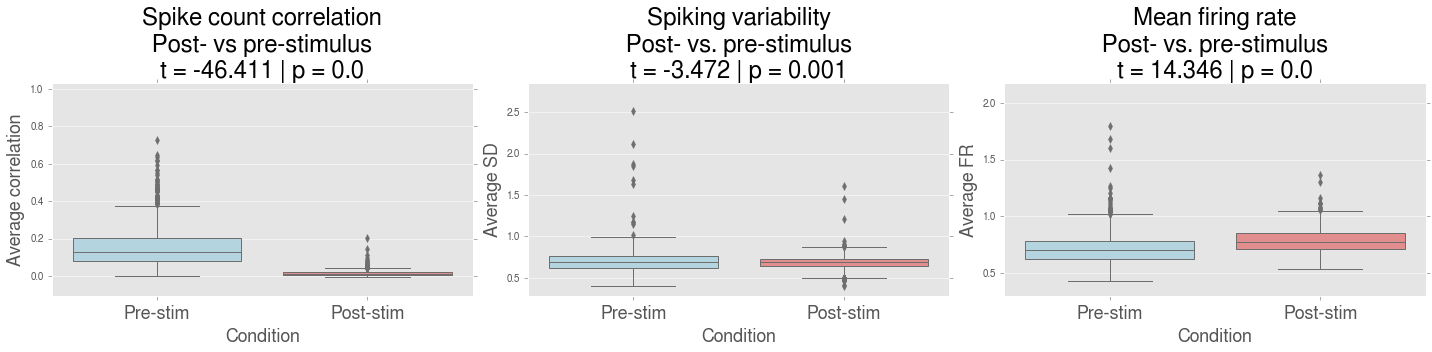

In [180]:
plt.figure(figsize=(20,5))
t, p = stats.ttest_rel(postCorr_avg,preCorr_avg)
# t, p = stats.wilcoxon(postCorr_avg,preCorr_avg)
plt.subplot(131)
tmpdat = [preCorr_avg,postCorr_avg]
sns.boxplot(data=tmpdat,palette=["#add8e6","#f08080"])
plt.xticks(np.arange(2),['Pre-stim','Post-stim'],fontsize=18, fontname='FreeSans');
plt.title('Spike count correlation\nPost- vs pre-stimulus\nt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)) ,fontsize=24,fontname='FreeSans')
print 'Spiking count correlation\n\tt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)),
plt.ylabel('Average correlation',fontsize=18,fontname='FreeSans')
plt.xlabel('Condition',fontsize=18,fontname='FreeSans')
plt.ylim([np.min(tmpdat)-np.std(tmpdat),np.max(tmpdat)+3*np.std(tmpdat)])


t, p = stats.ttest_rel(np.mean(postStimNoiseSD,0),np.mean(preStimNoiseSD,axis=0))
# t, p = stats.wilcoxon(np.mean(postStimNoiseSD**2,0),np.mean(preStimNoiseSD**2,axis=0))
plt.subplot(132)
tmpdat = [np.mean(preStimNoiseSD,axis=0),np.mean(postStimNoiseSD,0)]
sns.boxplot(data=tmpdat,palette=["#add8e6","#f08080"])
plt.xticks(np.arange(2),['Pre-stim','Post-stim'],fontsize=18, fontname='FreeSans');
plt.title('Spiking variability\nPost- vs. pre-stimulus\nt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)),fontsize=24,fontname='FreeSans')
print '\nSpiking variability\n\tt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)),
plt.ylabel('Average SD',fontsize=18,fontname='FreeSans')
plt.xlabel('Condition',fontsize=18,fontname='FreeSans')
plt.ylim([np.min(tmpdat)-np.std(tmpdat),np.max(tmpdat)+3*np.std(tmpdat)])


t, p = stats.ttest_rel(np.mean(postStimFR,0),np.mean(preStimFR,axis=0))
print '\nMean firing rate\n\tt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)),
# t, p = stats.wilcoxon(np.mean(postStimFR,0),np.mean(preStimFR,axis=0))
plt.subplot(133)
tmpdat = [np.mean(preStimFR,axis=0),np.mean(postStimFR,0)]
sns.boxplot(data=tmpdat,palette=["#add8e6","#f08080"])
plt.xticks(np.arange(2),['Pre-stim','Post-stim'],fontsize=18, fontname='FreeSans');
plt.title('Mean firing rate\nPost- vs. pre-stimulus\nt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)),fontsize=24,fontname='FreeSans')
plt.ylabel('Average FR',fontsize=18,fontname='FreeSans')
plt.xlabel('Condition',fontsize=18,fontname='FreeSans')
plt.ylim([np.min(tmpdat)-np.std(tmpdat),np.max(tmpdat)+3*np.std(tmpdat)])
plt.tight_layout()
